In [1]:
import scipy.io
import os
import sys
sys.path.insert(0,'..')
from rnn.model import RNN
from rnn.task import trial_generator
import numpy as np
from analysis.tf_utils import *
from analysis.analysis_utils import *
from scipy.stats import zscore
from itertools import permutations
import copy
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.animation import FuncAnimation
# from parula import Parula
from cycler import cycler
from analysis.summary import run_summary
from matplotlib import gridspec
from matplotlib.ticker import StrMethodFormatter
import pickle
%matplotlib inline

# Experiment settings

In [2]:
base_dir = ""
task_dir = "datasweep_retrain10.pkl"
#task_dir = "datasweep_c.pkl"
#task_dir = "datasweep_main.pkl"

summary_settings = {
    "upsample" : 1, # Increase temporal resolution
    "ref_phase" : "sine", # Reference phase for 'spike-phase' histogram, either sine or LFP
    "onlyGaba" : False,  # Only use inhibitory neurons for calculating LFP
    "cutoff_p": 10e-3, # For Wilc p test
    "normalize_fr_extract":  True,  # Normalize extracted firing rates
    "n_trials": 224,  # Number trials used in analysis
    "randomize_onset": False, # Randomise stimulus onset
    "delay_ms": 2500, # Delay time in ms
    "disable_noise": False, # With or without noise
    "freqs_l": np.logspace(*np.log10([1, 25]), num=50), # Frequencies for spectrograms
    "balance_trials": True, # Draw trials with balanced proportion of each stimuli
    "substr_mean_LFP": False, # Substract mean LFP
    "delay_buffer1": 25, # Disregard short period after stimulus offset
    "delay_buffer2": 25, # Disregard short period before probe onset
    "nbins": 20, # Number of bins for 'spike' phase histograms
    "common_baseline" : True, # Common baseline
    "freqs": [1, 1.5, 1.75, 2.04, 2.37, 2.75, 3.21, 3.73, 4.35, 5], # Frequencies for vex plots
    "ISIs":[10,40]
}
pltcolors, pltcolors_alt = steffiscolours()


# Run or load summary over many models

In [3]:
vex=False

model_dir = os.path.join(base_dir, "..", "models/sweep_main")
data_dir = "../data/"+str(task_dir)
data_list, summary_settings = run_summary(summary_settings, model_dir, data_dir,vex=vex)


removing: .DS_Store


# Generate plots

excluding N_items_4_N_200_Delay_260_Acc_0.859375_tr1_2023_04_21_160411.mat
excluding N_items_4_N_200_Delay_260_Acc_0.859375_tr1_2023_04_21_160411.mat
excluding N_items_4_N_200_Delay_260_Acc_0.859375_tr1_2023_04_21_160411.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8828125_tr101_2023_04_21_154006.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8828125_tr101_2023_04_21_154006.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8828125_tr101_2023_04_21_154006.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8046875_tr501_2023_04_21_145018.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8046875_tr501_2023_04_21_145018.mat
excluding N_items_4_N_200_Delay_260_Acc_0.8046875_tr501_2023_04_21_145018.mat


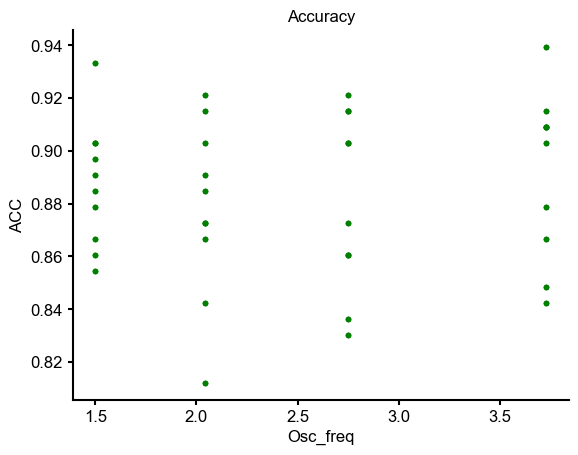

In [4]:
# Plot accuracies of all trained models over Freq

acc_threshold = 0.70
acc_indices = []
for i in range(len(data_list["or_acc"])):
    if data_list["model_names"][i][0]=='N':
        print("excluding " + data_list["model_names"][i])
    elif data_list["or_acc"][i]>acc_threshold:
        plt.scatter(data_list["loss_f"][i], data_list["or_acc"][i], color = 'green')
        acc_indices.append(i)
    else:
        plt.scatter(data_list["loss_f"][i], data_list["or_acc"][i], color = 'red')

plt.xlabel("Osc_freq")
plt.ylabel("ACC")
plt.title("Accuracy");

In [5]:
len(data_list["or_acc"])

129

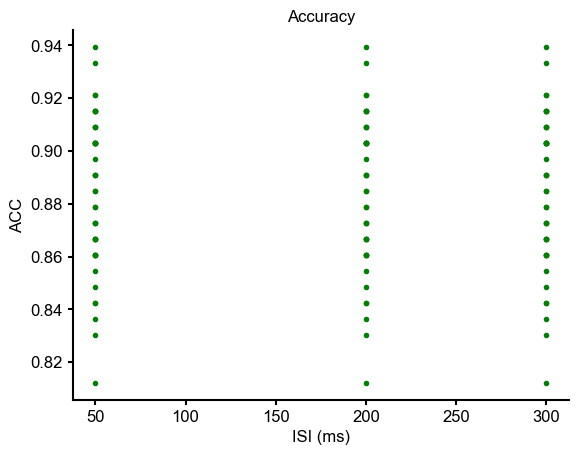

In [6]:
# Plot accuracies of all trained models over ISI

for i in range(len(data_list["acc"])):
    if data_list["or_acc"][i]>acc_threshold:
        plt.scatter(data_list["ISI"][i]*10, data_list["or_acc"][i], color = 'green')
    else:
        plt.scatter(data_list["ISI"][i]*10, data_list["or_acc"][i], color = 'red')

plt.xlabel("ISI (ms)")
plt.ylabel("ACC")
plt.title("Accuracy");

In [7]:
#for i in acc_indices:
#    plt.scatter(fr_l[np.argmax(np.mean(data_list["post_spectrum"][i],axis=1))],data_list['vex_f'][i])

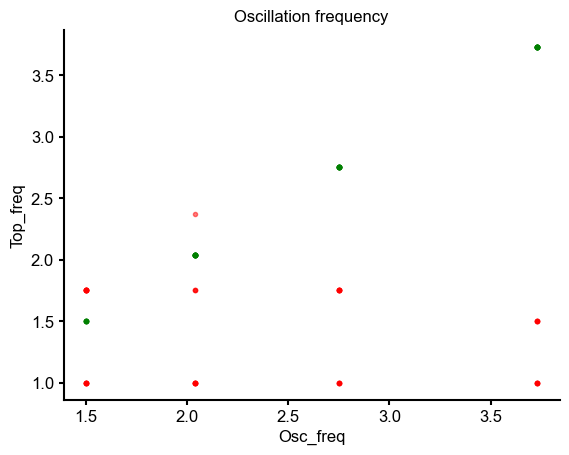

In [8]:
# Plot oscillation frequency for all trained models

fr_l = data_list["summary_settings"]["freqs_l"]
plt_indices = []
for i in acc_indices:
    #osc_freq = fr_l[np.argmax(np.mean(data_list["post_spectrum"][i],axis=1))]
    osc_freq = data_list['vex_f'][i]
    if (np.isclose(data_list["loss_f"][i], osc_freq, atol=.2)): #and 
        #np.isclose(osc_freq,data_list['vex_f'][i], atol=.5)):
        plt.scatter(data_list["loss_f"][i],osc_freq, color = 'green', alpha = 0.5)
        plt_indices.append(i)

    else:
        plt.scatter(data_list["loss_f"][i], osc_freq, color = 'red', alpha = 0.5)
plt.xlabel("Osc_freq")
plt.ylabel("Top_freq")
plt.title("Oscillation frequency");


In [9]:

if vex:
    # Plot Kappa per frequency, upper versus lower percentile d'

    kappa_all =([np.array(data_list["kappas"][i][:,np.mean(data_list["vex"][i],axis=0)!=0]).T for i in plt_indices])
    low_kappa_all = ([np.array(data_list["low_kappas"][i][:,np.mean(data_list["low_vex"][i],axis=0)!=0]).T for i in plt_indices])

    shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]

    kappas = []
    kappas_se = []
    low_kappas = []
    low_kappas_se = []

    frs = [1.5, 2.04, 2.75, 3.73]
    atol = [0.1,0.1,0.1,0.1]
    for fri, fr in enumerate(frs):
        kappa = [] 
        low_kappa = []
        incl_freq = False
        for i, ni in enumerate(plt_indices):
            if np.isclose(data_list["loss_f"][ni],fr, atol = atol[fri]):
                incl_freq=True
                kappa.append(kappa_all[i])
                low_kappa.append(low_kappa_all[i])

        if incl_freq:
            print("Including frequency " + str(fr) + " n = " + str(len(kappa)))
            kappas.append(np.mean(np.concatenate(kappa),axis = 0))
            kappas_se.append(np.std([np.mean(kappa[i]) for i in range(len(kappa))])/np.sqrt(len(kappa)))
            low_kappas.append(np.mean(np.concatenate(low_kappa),axis = 0))
            low_kappas_se.append(np.std([np.mean(low_kappa[i]) for i in range(len(low_kappa))])/np.sqrt(len(low_kappa)))





    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                kappas[i],
                kappas_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                low_kappas[i],
                low_kappas_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )

        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_kappas[i],
            low_kappas_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="low 50th",
        )
        axs.set_yticks(np.arange(0, 0.32, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("Kappa")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/Kappa_per_F_and_Perc.eps")

In [10]:
# Plot Vex per frequency, upper versus lower percentile d'
frs = [1.5, 2.04, 2.75, 3.73]

if "perm_new" in data_list:
    perms= np.array([[3,1,2],[1,3,2],[3,2,1],[2,3,1],[1,2,3],[2,1,3]])
else:
    perms = np.array([[1,3,2],[1,2,3],[2,1,3],[3,2,1],[3,1,2],[2,3,1]])

shcolors = [[0.8,0.8,0.8],[0.7,0.7,0.7],[0.6,0.6,0.6],[0.5,0.5,0.5]]
if vex:

    vexall =([np.array(data_list["vex"][i][:,np.mean(data_list["vex"][i],axis=0)!=0]).T for i in plt_indices])
    shvexall = ([np.array(data_list["shvex"][i][:,np.mean(data_list["vex"][i],axis=0)!=0]).T for i in plt_indices])
    low_vexall =([np.array(data_list["low_vex"][i][:,np.mean(data_list["low_vex"][i],axis=0)!=0]).T for i in plt_indices])
    low_shvexall = ([np.array(data_list["low_shvex"][i][:,np.mean(data_list["low_vex"][i],axis=0)!=0]).T for i in plt_indices])


    vexs = []
    shvexs = []
    low_vexs = []
    low_shvexs = []
    vexs_se = []
    shvexs_se = []
    low_vexs_se = []
    low_shvexs_se = []

    atol = [0.2,0.2,0.2,0.2]
    for fri, fr in enumerate(frs):
        vex = [] 
        shvex = []
        low_vex = [] 
        low_shvex = []
        incl_freq = False
        for i, ni in enumerate(plt_indices):
            if np.isclose(data_list["loss_f"][ni],fr, atol = atol[fri]):
                incl_freq=True
                vex.append(vexall[i])
                shvex.append(shvexall[i])
                low_vex.append(low_vexall[i])
                low_shvex.append(low_shvexall[i])
        if incl_freq:
            print("Including frequency " + str(fr) + " n = " + str(len(vex)))
            vexs.append(np.mean(np.concatenate(vex),axis = 0))
            shvexs.append(np.mean(np.concatenate(shvex),axis = 0))
            vexs_se.append(np.std([np.mean(vex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))
            shvexs_se.append(np.std([np.mean(shvex[i]) for i in range(len(shvex))])/np.sqrt(len(vex)))

            low_vexs.append(np.mean(np.concatenate(low_vex),axis = 0))
            low_shvexs.append(np.mean(np.concatenate(low_shvex),axis = 0))
            low_vexs_se.append(np.std([np.mean(low_vex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))
            low_shvexs_se.append(np.std([np.mean(low_shvex[i]) for i in range(len(low_shvex))])/np.sqrt(len(low_vex)))    




    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                vexs[i],
                vexs_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                low_vexs[i],
                low_vexs_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            low_vexs[i],
            low_vexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="low 50th",
        )
        axs.set_ylim(-0.02, 0.15)
        axs.set_yticks(np.arange(0, 0.13, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("variance explained")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/Vex_per_F_and_Perc.eps")

In [11]:
# Plot Vex per frequency, non-shuffled versus shuffled
if vex:
    with mpl.rc_context(fname="matplotlibrc"):

        fig, axs = plt.subplots(1, figsize=(3.2, 2.7))
        # fig.suptitle("Mean circular variance explained", fontsize = 16)
        fig.tight_layout()
        for i in range(len(kappas)):
            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                vexs[i],
                vexs_se[i],
                marker="o",
                color=pltcolors_alt[i],
                zorder=i+5,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
                label=str(frs[i])+" Hz",
            )  

            axs.errorbar(
                np.arange(len(summary_settings["freqs"])),
                shvexs[i],#, axis=0),
                shvexs_se[i],
                marker="o",
                color=shcolors[i],
                zorder=i,
                capsize=5,
                elinewidth=2,
                markeredgewidth=2,
            )
        axs.errorbar(
            np.arange(len(summary_settings["freqs"])),
            shvexs[i],#, axis=0),
            shvexs_se[i],
            marker="o",
            color=shcolors[i],
            zorder=i,
            capsize=5,
            elinewidth=2,
            markeredgewidth=2,
            label="shuffled",
        )
        axs.set_ylim(-0.02, 0.14)
        axs.set_yticks(np.arange(0, 0.13, 0.05))

        axs.set_xticks(np.arange(len(summary_settings["freqs"]))[::2])
        axs.set_xticklabels(["{:.1f}".format(fr) for fr in summary_settings["freqs"][::2]])
        axs.spines["right"].set_visible(False)
        axs.spines["top"].set_visible(False)
        axs.set_ylabel("variance explained")
        axs.set_xlabel("frequency (Hz)")

        handles, labels = axs.get_legend_handles_labels()
        # remove the errorbars
        handles = [h[0] for h in handles]
        # use them in the legend
        plt.legend(
            handles, labels, numpoints=1, loc="upper right", bbox_to_anchor=(1.4, 1.1)
        )
        plt.savefig("../figures/SummF", facecolor="None", transparent=True)
        plt.savefig("../figures/VEX_per_F_and_Shuffle.eps")

Including frequency 1.5 n = 9
Including frequency 2.04 n = 17
Including frequency 2.75 n = 15
Including frequency 3.73 n = 17


/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


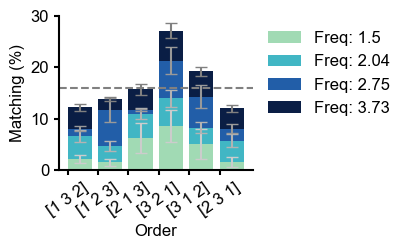

In [12]:
# Plot proportions of phase orders exploited by models from each training frequency


phase_orders = []
phase_orders_v = []
for fr in frs:
    phase_orders_fr = [] 
    incl_freq = False
    for i in plt_indices:
        if np.isclose(data_list["loss_f"][i],fr, atol = 0.2):
            incl_freq=True
            phase_orders_fr.append(np.array(data_list["phase_order"][i])/np.sum(data_list["phase_order"][i]))
    if incl_freq:
        print("Including frequency " + str(fr) + " n = " + str(len(phase_orders_fr)))
        phase_orders.append(np.mean(phase_orders_fr, axis = 0))
        phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))


with mpl.rc_context(fname="matplotlibrc"):

    plt.subplots(figsize=(2.5, 2))
    ax1 = plt.subplot(111, facecolor="white")  # , projection='polar')
    
    ax1.bar(np.arange(len(perms)),phase_orders[0]*25, color=pltcolors_alt[0],
            yerr=phase_orders_v[0]*25, 
            align='edge',  ecolor=shcolors[0], capsize=4, label ='Freq: '+ str(frs[0]))
    for i in range(1,len(phase_orders)):
        ax1.bar(np.arange(len(perms)),phase_orders[i]*25, color=pltcolors_alt[i], bottom = np.sum(phase_orders[:i],axis = 0)*25,
            yerr=phase_orders_v[i]*25, 
            align='edge',  ecolor=shcolors[i], capsize=4, label ='Freq: '+ str(frs[i]))
     
    ax1.legend(bbox_to_anchor = (1,1))
    ax1.axhline(16, linestyle="--", color="grey")
    ax1.set_ylim(0)#, 35)
    ax1.set_xticks(np.arange(len(perms)))
    plt.xticks(rotation=35)
    plt.xlabel("Order")

    ax1.set_xticklabels(perms)
    ax1.set_ylabel("Matching (%)")

    plt.savefig("../figures/model_phaseorders.eps")

/opt/homebrew/Caskroom/miniforge/base/envs/PhaseC/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:
findfont: Font family ['serif'] not found. Falling back to Helvetica.
findfont: Generic family 'serif' not found because none of the following families were found: Arial, sans-serif


Including frequency 1.5, 
 ISI 5, n = 3
Including frequency 1.5, 
 ISI 20, n = 3
Including frequency 1.5, 
 ISI 30, n = 3
Including frequency 2.04, 
 ISI 5, n = 6
Including frequency 2.04, 
 ISI 20, n = 5
Including frequency 2.04, 
 ISI 30, n = 6
Including frequency 2.75, 
 ISI 5, n = 5
Including frequency 2.75, 
 ISI 20, n = 5
Including frequency 2.75, 
 ISI 30, n = 5
Including frequency 3.73, 
 ISI 5, n = 6
Including frequency 3.73, 
 ISI 20, n = 7
Including frequency 3.73, 
 ISI 30, n = 4
PREDICTION
4 [3 1 2] 1.5 250
111
PREDICTION
2 [2 1 3] 1.5 400
212
PREDICTION
3 [3 2 1] 1.5 500
313
PREDICTION
2 [2 1 3] 2.04 250
414
PREDICTION
3 [3 2 1] 2.04 400
515
PREDICTION
1 [1 2 3] 2.04 500
616
PREDICTION
3 [3 2 1] 2.75 250
717
PREDICTION
1 [1 2 3] 2.75 400
818
PREDICTION
4 [3 1 2] 2.75 500
919
PREDICTION
3 [3 2 1] 3.73 250
1020
PREDICTION
4 [3 1 2] 3.73 400
1121
PREDICTION
3 [3 2 1] 3.73 500
1222


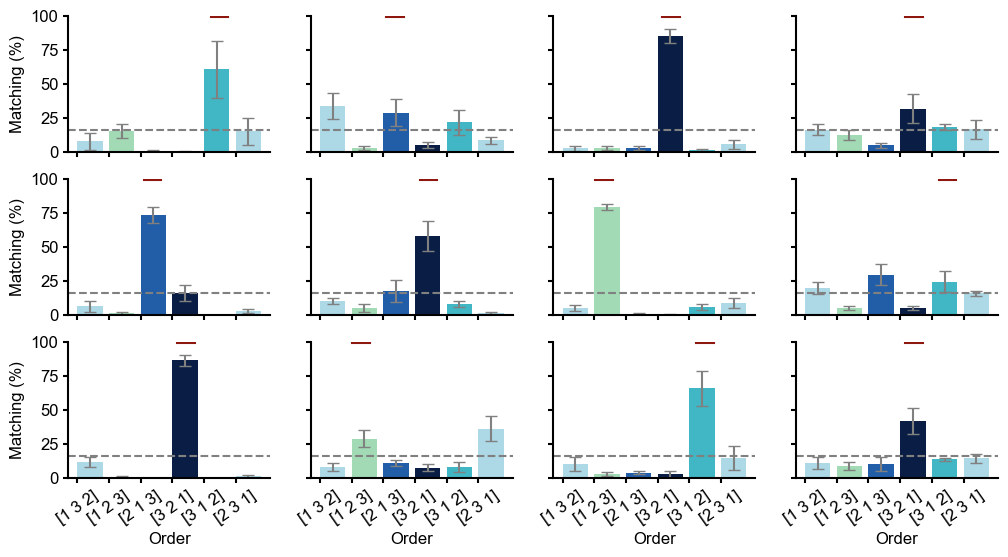

In [13]:
# Plot proportions of phase orders exploited by models from each training frequency and ISI, in seperate plots

phase_orders = []
phase_orders_v = []
freq_ISI = []
freqInds=[]
ISIInds=[]

ISIs=[5,20,30]

result =np.zeros((len(ISIs),len(frs)))

for i_fr,fr in enumerate(frs):
    for i_ISI, ISI in enumerate(ISIs):
        phase_orders_fr = [] 
        incl_freq_ISI = False
        
        #loop through all models
        for i in plt_indices:
            if np.isclose(data_list["loss_f"][i],fr, atol = 0.2):
                if np.isclose(data_list["ISI"][i],ISI, atol = 2):
                    incl_freq_ISI=True
                    phase_orders_fr.append(np.array(data_list["phase_order"][i])/np.sum(data_list["phase_order"][i]))
        # Summary of particular models with freq and ISI
        if incl_freq_ISI:
            print("Including frequency " + str(fr) + ", \n ISI " + str(ISI) +  ", n = " + str(len(phase_orders_fr)))
            phase_orders.append(np.mean(phase_orders_fr, axis = 0))
            phase_orders_v.append(np.std(phase_orders_fr, axis = 0)/np.sqrt(len(phase_orders_fr)))
            freq_ISI.append("F: " +str(fr) + ", ISI: "+str(ISI*10+200))
            freqInds.append(i_fr)
            ISIInds.append(i_ISI)

fig=plt.figure(figsize=(12, 6))


colors = ['lightblue',pltcolors_alt[0],pltcolors_alt[2],pltcolors_alt[3],pltcolors_alt[1],'lightblue']

def plt_ind(i):
    return ((i*4+1)%12)+i//3

with mpl.rc_context(fname="matplotlibrc"):
    for i in range(len(phase_orders)):
        pred_i, pred = get_phase_order(frs[freqInds[i]],ISIs[ISIInds[i]]*10+200)
        if "perm_new" not in data_list:
            pred_i=new_to_old_perm_inds(pred_i)
        print("PREDICTION")
        print(pred_i,pred,frs[freqInds[i]],ISIs[ISIInds[i]]*10+200)
        result[ISIInds[i],freqInds[i]]=phase_orders[i][pred_i]*100
        
        print((i+1)*100+11+i)
        #ax1 = plt.subplot(101+len(phase_orders)*10+i, facecolor="white")  
        1,5,9,2,6,10,3,7,11,4,8,12
        ax1 = fig.add_subplot(3, 4,plt_ind(i))
        ax1.bar(np.arange(len(perms)),phase_orders[i]*100, color=colors,
                yerr=phase_orders_v[i]*100, 
                align='edge',  ecolor=shcolors[-1], capsize=4)#, label ='Freq: '+ str(frs[i]))
        #ax1.set_title(freq_ISI[i])
        ax1.axhline(16, linestyle="--", color="grey")
        ax1.axhline(99,pred_i/6+0.04,(pred_i+1)/6-0.04, linestyle="-", color=pltcolors[-1])

    
        ax1.set_ylim(0,100)
        ax1.set_xticks(np.arange(len(perms)))
        plt.xticks(rotation=35)
        if plt_ind(i)>8:
            ax1.set_xticklabels(perms)
            ax1.set_xlabel("Order")

        else:
            ax1.set_xticklabels([])
        if not i//3==0:
            ax1.set_yticklabels([])
        else:
            ax1.set_ylabel("Matching (%)")

    plt.rcParams["pdf.use14corefonts"] = True


    plt.savefig("../figures/model_phaseorders_sem.pdf", facecolor='white')

In [21]:
def add_numbers(ax, grid, fontsize,float_labels=False,atol=0.1):
    """add numbers to covariance matrix plots"""
    for (j, i), label in np.ndenumerate(grid):
        if not np.isclose(label, 0, atol=atol):
            if float_labels:
                ax.text(i, j, "{:.2f}".format(label), ha="center", va="center", fontsize=fontsize)
            else:
                ax.text(i, j, int(label), ha="center", va="center", fontsize=fontsize)


(0.0, 150.0)


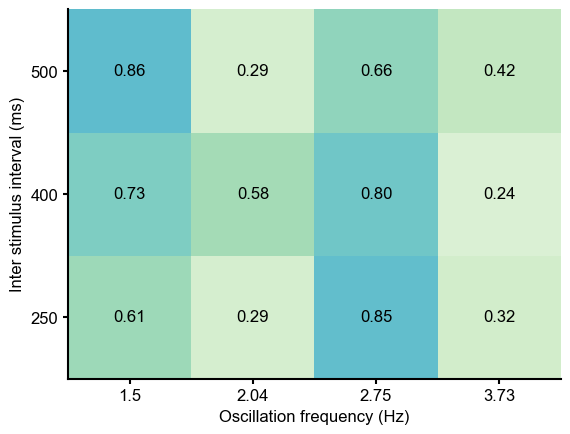

In [22]:
plt.imshow(result,origin='lower',cmap='GnBu',vmin=0,vmax=150)
plt.xticks(np.arange(len(frs)),frs)
plt.yticks(np.arange(len(ISIs)),[ISI*10+200 for ISI in ISIs])
plt.ylabel("Inter stimulus interval (ms)")
plt.xlabel("Oscillation frequency (Hz)")
add_numbers(plt.gca(),result/100,12,float_labels=True)
print(plt.gci().get_clim())

In [23]:
get_phase_order(3.73,400)

(0, array([3, 1, 2]))

In [24]:
np.mean(result)

55.422813726039216